In [4]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

F:\Users\Raven\AppData\Local\Continuum\anaconda3\envs\tf20\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# rcParams['figure.figsize'] = (50,10)

In [3]:
ukdale = DataSet('./dataset/ukdale.h5')

In [4]:
print_dict(ukdale.buildings)

In [5]:
print_dict(ukdale.buildings[5].metadata)

In [18]:
ukdale.set_window(start = "2014-07-07", end = "2014-07-14")

elec = ukdale.buildings[5].elec
elec

MeterGroup(meters=
  ElecMeter(instance=2, building=5, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])
  ElecMeter(instance=3, building=5, dataset='UK-DALE', appliances=[Appliance(type='desktop computer', instance=1)])
  ElecMeter(instance=4, building=5, dataset='UK-DALE', appliances=[Appliance(type='hair dryer', instance=1)])
  ElecMeter(instance=5, building=5, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=6, building=5, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])
  ElecMeter(instance=7, building=5, dataset='UK-DALE', appliances=[Appliance(type='running machine', instance=1)])
  ElecMeter(instance=8, building=5, dataset='UK-DALE', appliances=[Appliance(type='network attached storage', instance=1)])
  ElecMeter(instance=9, building=5, dataset='UK-DALE', appliances=[Appliance(type='server computer', instance=1)])
  ElecMeter(instance=10, building=5, dataset='UK-DALE', appli

In [19]:
fridge = elec['fridge freezer']
fridge.available_columns()
fridge_df = next(fridge.load())

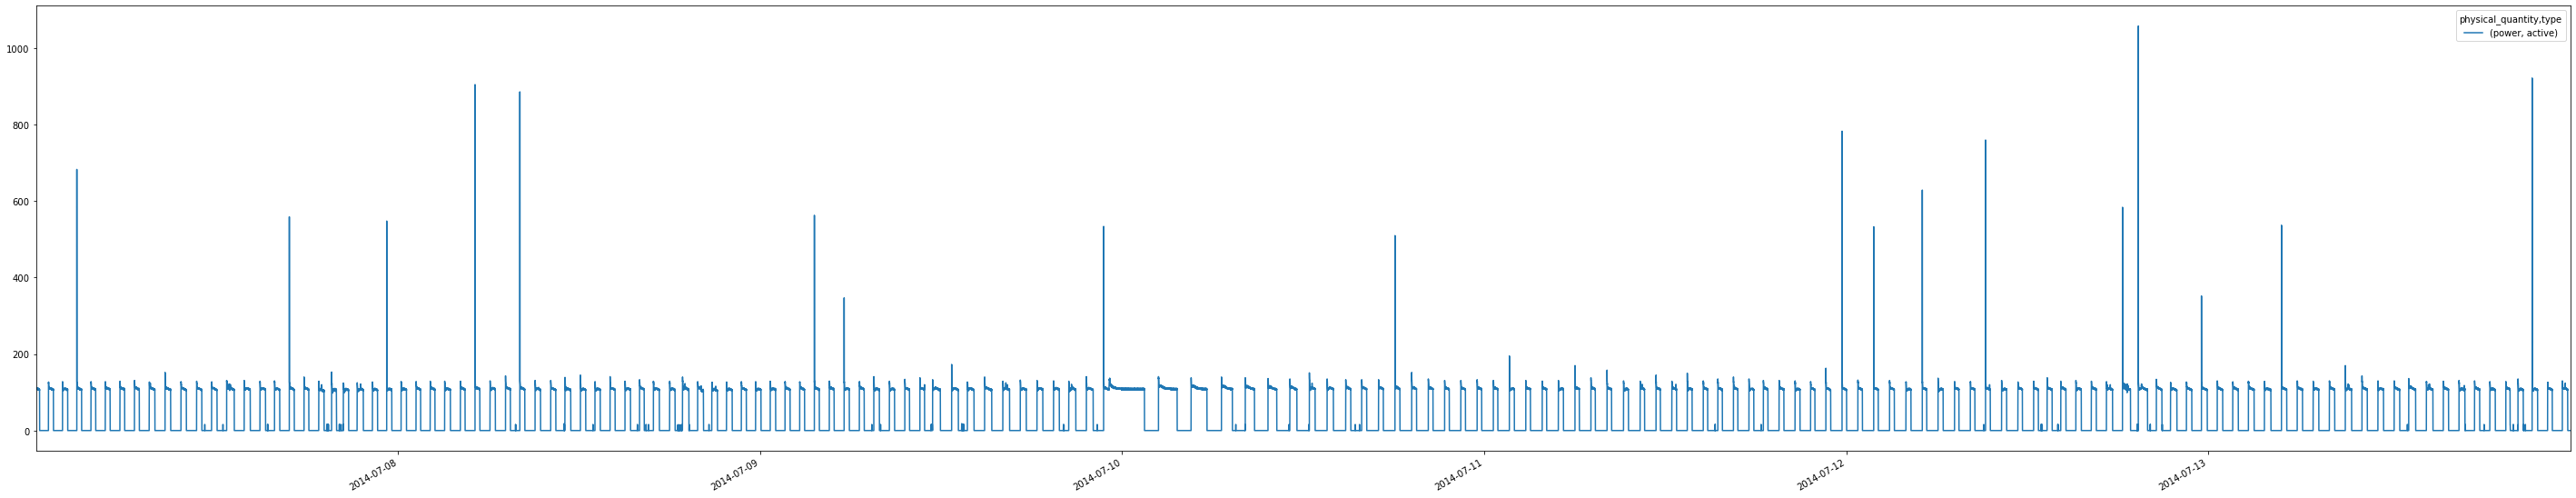

In [20]:
fridge_df.plot()

In [21]:
data = fridge_df
data

physical_quantity,power
type,active
2014-07-07 00:00:03+01:00,110.0
2014-07-07 00:00:09+01:00,109.0
2014-07-07 00:00:15+01:00,110.0
2014-07-07 00:00:21+01:00,112.0
2014-07-07 00:00:27+01:00,112.0
2014-07-07 00:00:33+01:00,110.0
2014-07-07 00:00:39+01:00,109.0
2014-07-07 00:00:45+01:00,111.0
2014-07-07 00:00:51+01:00,112.0


In [78]:
data.shape, len(data)

((98071, 1), 98071)

In [79]:
seq_length = 5*60*10
delay = 1*60*10

In [80]:
data_ = []
for i in range(len(data)- seq_length - delay):
    data_.append(data.iloc[i : i+seq_length +delay])

In [81]:
data_[0].shape


(3600, 1)

In [82]:
data_ = np.array([df.values for df in data_])

In [83]:
data_.shape

(94471, 3600, 1)

In [84]:
np.random.shuffle(data_)

In [85]:
x = data_[:, :5*60*10, :]
y = data_[:,-1, 0]
x.shape, y.shape

((94471, 3000, 1), (94471,))

In [86]:
split_b = int(data_.shape[0]*0.8)

In [87]:
train_x = x[ :split_b]
train_y = y[ :split_b]
test_x = x[split_b: ]
test_y = y[split_b: ]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((75576, 3000, 1), (75576,), (18895, 3000, 1), (18895,))

In [88]:
# mean = train_x.mean(axis = 0)
# std = train_x.std(axis = 0)

In [89]:
# train_x = (train_x - mean)/std
# test_x = (test_x - mean)/std

In [90]:
batch_size = 200

### Fully connected NN

In [91]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape = (train_x.shape[1:])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               384128    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 388,289
Trainable params: 388,289
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(optimizer='adam',
             loss = 'mse',
             metrics = ['mae'])

In [94]:
history = model.fit(train_x, train_y,
                   batch_size = batch_size,
                   epochs = 100,
                   validation_data = (test_x, test_y))

Train on 75576 samples, validate on 18895 samples
Epoch 1/100
75576/75576 [==============================] - 8s 111us/sample - loss: 1796.7254 - mae: 26.1379 - val_loss: 1008.9690 - val_mae: 21.3773
Epoch 2/100
75576/75576 [==============================] - 3s 37us/sample - loss: 963.7274 - mae: 20.4962 - val_loss: 928.3654 - val_mae: 20.1796
Epoch 3/100
75576/75576 [==============================] - 3s 37us/sample - loss: 834.5533 - mae: 18.5817 - val_loss: 799.9970 - val_mae: 17.8762
Epoch 4/100
75576/75576 [==============================] - 3s 37us/sample - loss: 747.5101 - mae: 17.1915 - val_loss: 724.9774 - val_mae: 17.5397
Epoch 5/100
75576/75576 [==============================] - 3s 37us/sample - loss: 677.6506 - mae: 15.9816 - val_loss: 693.1840 - val_mae: 15.9605
Epoch 6/100
75576/75576 [==============================] - 3s 37us/sample - loss: 621.9508 - mae: 15.0897 - val_loss: 614.6326 - val_mae: 14.9176
Epoch 7/100
75576/75576 [==============================] - 3s 37us/samp

Epoch 57/100
75576/75576 [==============================] - 3s 37us/sample - loss: 118.7413 - mae: 5.2138 - val_loss: 219.1984 - val_mae: 5.3863
Epoch 58/100
75576/75576 [==============================] - 3s 39us/sample - loss: 108.2494 - mae: 4.8954 - val_loss: 269.2907 - val_mae: 6.7111
Epoch 59/100
75576/75576 [==============================] - 3s 39us/sample - loss: 109.6327 - mae: 4.8718 - val_loss: 209.1585 - val_mae: 5.5605
Epoch 60/100
75576/75576 [==============================] - 3s 37us/sample - loss: 102.9041 - mae: 4.7941 - val_loss: 250.2179 - val_mae: 6.4177
Epoch 61/100
75576/75576 [==============================] - 3s 36us/sample - loss: 124.1813 - mae: 5.2009 - val_loss: 272.7714 - val_mae: 8.2377
Epoch 62/100
75576/75576 [==============================] - 3s 37us/sample - loss: 104.4992 - mae: 4.8964 - val_loss: 211.0296 - val_mae: 5.4419
Epoch 63/100
75576/75576 [==============================] - 3s 37us/sample - loss: 103.2342 - mae: 4.7942 - val_loss: 225.9991 - v

In [95]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

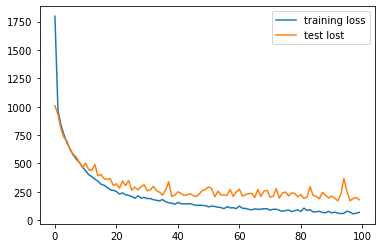

In [96]:
plt.plot(history.epoch, history.history.get('loss'), label = "training loss")
plt.plot(history.epoch, history.history.get('val_loss'), label = 'test lost')
plt.legend()

### Simple LSTM

In [98]:
model_l1 = keras.Sequential()
model_l1.add(layers.LSTM(32, input_shape=(train_x.shape[1:])))
model_l1.add(layers.Dense(1))

In [99]:
model_l1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [101]:
model_l1.compile(optimizer='adam',
             loss = 'mse',
             metrics = ['mae'])

In [106]:
history_l1 = model_l1.fit(train_x, train_y,
                    batch_size = batch_size,
                    epochs = 100, 
                    validation_data =(test_x, test_y) )

Train on 75576 samples, validate on 18895 samples
Epoch 1/100
75576/75576 [==============================] - 54s 721us/sample - loss: 1334.5870 - mae: 23.2014 - val_loss: 1287.0487 - val_mae: 22.6965
Epoch 2/100
75576/75576 [==============================] - 54s 720us/sample - loss: 1303.2677 - mae: 22.7198 - val_loss: 1250.7924 - val_mae: 22.1463
Epoch 3/100
75576/75576 [==============================] - 55s 724us/sample - loss: 1267.3196 - mae: 22.1606 - val_loss: 1213.1032 - val_mae: 22.2622
Epoch 4/100
75576/75576 [==============================] - 55s 725us/sample - loss: 1270.1292 - mae: 22.1108 - val_loss: 1252.5085 - val_mae: 21.4941
Epoch 5/100
75576/75576 [==============================] - 55s 727us/sample - loss: 1385.5826 - mae: 23.6340 - val_loss: 1337.4438 - val_mae: 21.1984
Epoch 6/100
75576/75576 [==============================] - 55s 725us/sample - loss: 1349.7424 - mae: 22.2924 - val_loss: 1255.6812 - val_mae: 22.2920
Epoch 7/100
75576/75576 [=========================

Epoch 55/100
75576/75576 [==============================] - 55s 731us/sample - loss: 1173.9970 - mae: 19.6681 - val_loss: 1151.8961 - val_mae: 20.4655
Epoch 56/100
75576/75576 [==============================] - 55s 732us/sample - loss: 1168.6579 - mae: 19.5654 - val_loss: 1187.2125 - val_mae: 19.2125
Epoch 57/100
75576/75576 [==============================] - 55s 727us/sample - loss: 1152.7269 - mae: 19.2645 - val_loss: 1135.6229 - val_mae: 19.5343
Epoch 58/100
75576/75576 [==============================] - 55s 733us/sample - loss: 1156.4183 - mae: 19.5600 - val_loss: 1125.4682 - val_mae: 18.3330
Epoch 59/100
75576/75576 [==============================] - 55s 725us/sample - loss: 1135.1856 - mae: 19.0941 - val_loss: 1113.3653 - val_mae: 19.3385
Epoch 60/100
75576/75576 [==============================] - 55s 731us/sample - loss: 1106.6255 - mae: 18.6724 - val_loss: 1171.4281 - val_mae: 19.6333
Epoch 61/100
75576/75576 [==============================] - 55s 732us/sample - loss: 1135.8197

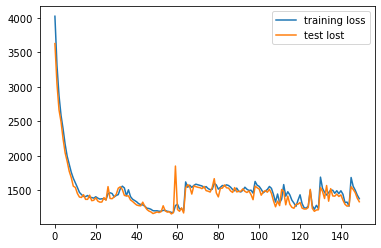

In [105]:
plt.plot(history_l1.epoch, history_l1.history.get('loss'), label = "training loss")
plt.plot(history_l1.epoch, history_l1.history.get('val_loss'), label = 'test lost')
plt.legend()